# Image classification through Spiking Neural Networks
This notebook presents the step-by-step development of an impulse neural network.
It is designed as part of the article: "From the Brain to the Machine: Digital Synapses with Spiking Neural Networks", for the scientific dissemination magazine on artificial intelligence, Komputer Sapiens. However, it is not necessary to have read this article.

### Importing Libraries
- import torch: Imports PyTorch, a deep learning library used to create and train neural networks.

- import torch.nn as nn: Imports the nn module from PyTorch, which contains tools for defining and working with neural network layers and functions.

- import snntorch as snn: provides tools for working with Spiking Neural Networks in PyTorch.

- import matplotlib.pyplot as plt: A library for creating visualizations such as plots and charts.

- from torchvision import datasets, transforms: Imports modules from torchvision for loading and transforming image datasets commonly used in computer vision tasks.

- from torch.utils.data import DataLoader: Imports DataLoader, which facilitates loading and managing data in mini-batches during training.

- from snntorch import spikegen: Used for generating spike-based input data for spiking neural networks.

In [2]:
import torch
import torch.nn as nn
import snntorch as snn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader
from snntorch import spikegen

This section of the code sets up the environment and prepares the dataset for processing. The `data_path` variable specifies the location where the MNIST dataset will be stored. It defines the data type for tensors as `torch.float` to optimize memory usage and compatibility with certain libraries. The `device` variable is configured to use a GPU if available (CUDA for NVIDIA GPUs or MPS for Apple Silicon), or defaults to the CPU otherwise. Finally, the `transform` variable creates a series of transformations applied to the dataset, including converting images to PyTorch tensors and normalizing them to have a mean of 0 and a standard deviation of 1.

In [3]:
data_path='/tmp/data/mnist'

# Torch Variables
dtype = torch.float       
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

This code snippet handles the loading and batching of the MNIST dataset. It sets the `batch_size` to 160 and loads the MNIST training and test datasets using the `datasets.MNIST` function, applying the previously defined transformations. Next, `DataLoader` objects are created for both the training and test datasets with the specified batch size and shuffling enabled to ensure random sampling of data. The sizes of these `DataLoader` objects indicate the number of batches in each loader.

In [4]:
batch_size=160
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
print(f"The size of mnist_train is {len(mnist_train)}")
print(f"The size of mnist_test is {len(mnist_test)}")
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
print(f"The size of train_loader is {len(train_loader)}")
print(f"The size of test_loader is {len(test_loader)}")


The size of mnist_train is 60000
The size of mnist_test is 10000
The size of train_loader is 375
The size of test_loader is 63


The `num_inputs` is set to 28*28 to match the flattened size of MNIST images, while `num_hidden` specifies the number of neurons in the hidden layer, and `num_outputs` corresponds to the number of classes (10 different digits) in the MNIST dataset. The `num_steps` variable defines the number of time steps used for the temporal coding of spikes, and `beta` is a parameter that controls the leaky integration in the leaky integrate-and-fire neuron model.

In [5]:
# Network Architecture
num_inputs = 28*28    
num_hidden = 64                         # You can increase the number of neurons
num_outputs = 10

# Temporal Dynamics
num_steps = 20                          #You can also change the number of time steps, 30, 50,          
beta = 0.95                             #60, etc... but consider that you add more computational cost

This section of the code defines a spiking neural network architecture using PyTorch. The `Net` class inherits from `nn.Module` and initializes two layers: `fc1` and `fc2`, which are fully connected layers for the input and hidden layers respectively. `snn.Leaky` is used to create leaky integrate-and-fire (LIF) neurons for each layer. 

At each time step:
- `cur1` and `cur2` represent the current input to the layers (`fc1` and `fc2`) respectively, with dimensions `[batch_size, num_hidden]` and `[batch_size, num_outputs]`.
- `spk1` and `spk2` represent the spike outputs from the LIF neurons, which are binary arrays (`0` or `1`) with the same dimensions as `cur1` and `cur2`.
- `mem1` and `mem2` are the membrane potentials of the LIF neurons, representing the internal state of the neuron. These tensors share the same dimensions as the spike outputs.

The output of the network is a sequence of tensors (`spk2_rec` and `mem2_rec`) stacked along the time dimension, resulting in dimensions `[num_steps, batch_size, num_outputs]`. These outputs capture the temporal evolution of spikes and membrane potentials across the network layers.

 The network is then loaded onto the available computational device, such as CUDA (GPU) if available.


In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)                    
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()                                
        mem2 = self.lif2.init_leaky()                               

        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)     
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)      

# Load the network onto CUDA if available
net = Net().to(device)

In this part of the code, the loss function and optimizer are set up for training the spiking neural network. 

- `CE_loss = nn.CrossEntropyLoss()` initializes the cross-entropy loss function. It compares the network's output predictions with the true labels and calculates a scalar value representing how far the predictions are from the actual classes.

- `optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))` sets up the Adam optimizer, a popular choice for training neural networks due to its ability to adapt the learning rate for each parameter. The learning rate (`lr`) is set to `5e-4`, and `betas` control the exponential decay rates for the moment estimates. This optimizer will adjust the network's parameters during backpropagation to minimize the loss.


In [7]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

This code block defines the training parameters and implements the training loop for the spiking neural network.

- **Training Parameters**: 
  - `num_epochs = 1`: The network will train for 1 epoch. 
  - `num_classes = 10`: Represents the number of output classes.
  - `loss_hist`: Lists initialized to store the history of training loss values across epochs.

- **Model Training Loop**: 
  - The loop iterates over each epoch. For each batch of data in the `train_loader`, the following steps are executed:
    1. **Rate Coding**: `spike_data = spikegen.rate(data, num_steps=num_steps)` converts the input data into spike trains using rate coding, where the number of spikes is proportional to the input intensity.
    2. **Data Preparation**: The spike data and targets are moved to the device (CPU, CUDA, or MPS) and reshaped to ensure correct dimensionality for the network.
    3. **Forward Pass**: The network's forward method processes the spike data, returning outputs and membrane potential recordings (`mem_rec`). The network is optimized based on the error between the predicted and actual labels.
    4. **Loss Calculation**: The loss value (`loss_val`) is accumulated over the `num_steps` time steps by applying the cross-entropy loss (`CE_loss`) to the membrane potential outputs at each time step.
    5. **Backpropagation and Optimization**: The accumulated loss is backpropagated, and the optimizer updates the network parameters to minimize the loss.
    6. **Logging**: The loss for the current epoch is stored and printed.

This loop trains the spiking neural network by iterating over the entire training dataset and updating the network's weights based on the loss calculated from the membrane potentials at each time step.


In [8]:
# Training Parameters
num_epochs = 1
num_classes = 10  
loss_hist = []
# Model training
for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        spike_data = spikegen.rate(data, num_steps=num_steps)
        spike_data = spike_data.to(device)                                 
        targets = targets.to(device) 
        spike_data = spike_data.view(num_steps, data.size(0), -1)
        optimizer.zero_grad()
        outputs, mem_rec = net(spike_data)
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += CE_loss(mem_rec[step], targets)          
        loss_hist.append(loss_val.item())
        loss_val.backward()
        optimizer.step() 
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val.item():.4f}")

torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
torch.Size([20, 160, 784])
t

### Testing the Spiking Neural Network Model

This code snippet is responsible for evaluating the trained Spiking Neural Network (SNN) on the test dataset to determine its accuracy in classifying the MNIST digits.

1. **Set the Network to Evaluation Mode**: 
   - The `net.eval()` function is called to switch the network to evaluation mode. It ensures that layers like dropout, which behave differently during training, are turned off during testing.

2. **Disable Gradient Calculation**:
   - The `torch.no_grad()` context is used to disable gradient calculation. This makes the code more memory-efficient and faster, as gradient information is not needed during testing.

3. **Iterate Over Test Dataset**:
   - The loop iterates over batches of data provided by `test_loader`.
     - **Data Preparation**:
       - The target labels (`targets`) are moved to the appropriate device (CPU, GPU, or MPS).
       - The input data (`data`) is converted to spike trains using `spikegen.rate()` with rate coding over `num_steps` time steps.
       - The spike data is then reshaped to have the correct dimensions for the network's input.
     - **Forward Pass**:
       - The network processes the spike data, producing an output for each time step and corresponding membrane potentials (`mem`).
     - **Prediction**:
       - The outputs from all time steps are summed across time (`outputs.sum(dim=0)`), providing a cumulative activation for each class.
       - The class with the highest activation is selected as the predicted label (`pred`).
     - **Accuracy Calculation**:
       - The predicted labels are compared to the true labels, and the number of correct predictions is accumulated in `correct`.
       - The total number of samples processed is tracked in `total`.

4. **Compute and Display Accuracy**:
   - The overall accuracy of the model on the test dataset is calculated as the percentage of correct predictions (`100 * correct / total`).


In [9]:
# Model test
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        targets = targets.to(device)
        spike_data = spikegen.rate(data, num_steps=num_steps)
        spike_data = spike_data.to(device)
        spike_data = spike_data.view(num_steps, data.size(0), -1)
        outputs, mem = net(spike_data)
        _, pred = outputs.sum(dim=0).max(1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")
accuracy = 100. * correct / len(test_loader.dataset)

Accuracy: 92.15%


And finally the best part of the task is to observe how the loss decreases through the iterations.

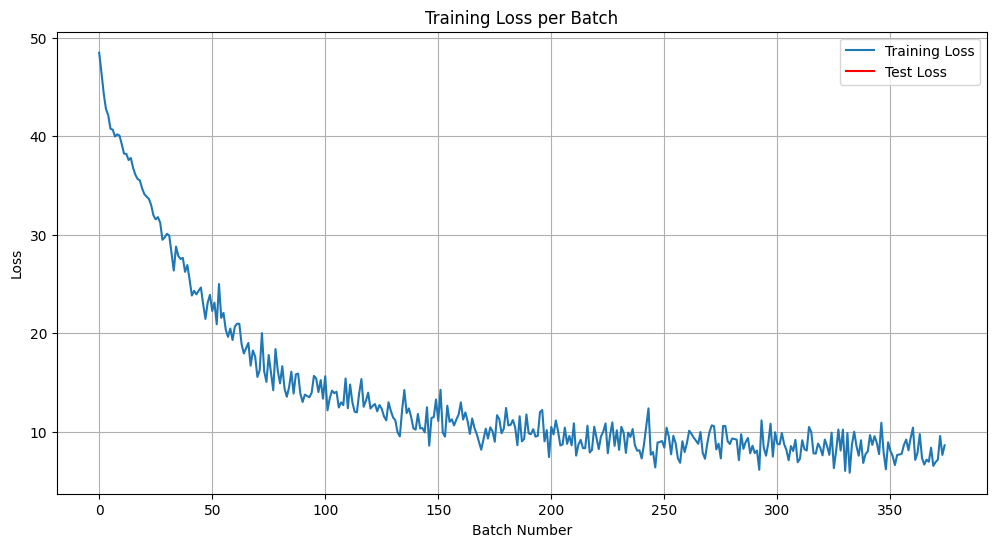

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.grid(True)
plt.show()